In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

- 분석계획
    - 사설 데이터-> 전국/지역 이슈 구분(키워드 분석) label-> 같은 지역내 신문들끼리의 키워드 분석-> 감성분석 -> 유사치 도출
    - 지역신문 top2 설정

1. 0410 (v1)
    - 일단은 crawl_v1에서 만들어낸 기사로 함
    - 나중에 big kinds 사이트에서 전문 기사 가져온것으로 분석
    

# 데이터 전처리

In [2]:
file_list = os.listdir('/Users/jihyejung/workspace/Dropbox/Research/신문차별화/data')
file_list

['.DS_Store',
 'News_전국_중앙일보_20080131-20151231.csv',
 'News_부산_부산일보_20080131-20151231.csv',
 'df_ols.csv',
 'News_부산_국제신문_20080131-20151231.csv',
 'News_전국_동아일보_20080131-20151231.csv',
 'News_전국_경향신문_20080131-20151231.csv']

In [3]:
file = '/Users/jihyejung/workspace/Dropbox/Research/신문차별화/data/'

df_joong =  pd.read_csv(file+'News_전국_중앙일보_20080131-20151231.csv', encoding='utf-8')
df_donga =  pd.read_csv(file+'News_전국_동아일보_20080131-20151231.csv', encoding='utf-8')
df_bu_1 =  pd.read_csv(file+'News_부산_국제신문_20080131-20151231.csv', encoding='utf-8')
df_bu_2 =  pd.read_csv(file+'News_부산_부산일보_20080131-20151231.csv', encoding='utf-8')
df_kyeong =  pd.read_csv(file+'News_전국_경향신문_20080131-20151231.csv', encoding='utf-8')

#Before
print(f'중앙일보 {len(df_joong)}')
print(f'동아일보 {len(df_donga)}')
print(f'국제신문 {len(df_bu_1)}')
print(f'부산일보 {len(df_bu_2)}')
print(f'경향신문 {len(df_bu_2)}')

df_joong.drop('Unnamed: 0', axis = 1, inplace = True)
df_donga.drop('Unnamed: 0', axis = 1, inplace = True)
df_bu_1.drop('Unnamed: 0', axis = 1, inplace = True)
df_bu_2.drop('Unnamed: 0', axis = 1, inplace = True)

#기사 본문있는것만 남기기
df_joong = df_joong[df_joong.본문_full != 'url_error']
df_donga = df_donga[df_donga.본문_full != 'url_error']
df_bu_1 = df_bu_1[~df_bu_1.본문_full.isna()]
df_bu_2 = df_bu_2[~df_bu_2.본문_full.isna()]
df_bu_2 = df_bu_2[df_bu_2.본문_full != 'url_error']

#header 수정
df_joong.본문_full.replace('\u3000','', inplace = True)
df_donga.본문_full = df_donga.본문_full.apply(lambda x: x.split('\n사설')[0].strip())
for i in range(len(df_bu_1.본문_full)):
    try:
        df_bu_1.본문_full.iloc[i] = df_bu_1.본문_full.iloc[i].replace('<div class="news_article">','')\
        .replace('\r\n\t\t\t\t','')\
        .replace('<br/><br/>','')\
        .replace('</div>','')
    except:
        print(i)
for i in range(len(df_bu_2.본문_full)):
    try:
        df_bu_2.본문_full.iloc[i] = df_bu_2.본문_full.iloc[i].replace('<div class="article_content">\n<p class="subtitle">','')\
        .replace('\n</p>\n<p><p>','')\
        .replace('<br/><br/>','')\
        .replace('<br><br/>','')\
        .replace('</br></p></p>\n<br/>\n<p></p>\n</div>','')
    except:
        print(i)
#re.sub('<.+?>', '', df_bu_1.본문_full[0], 0).strip()

df_kyeong.drop('Unnamed: 0', axis = 1, inplace = True)
df_kyeong = df_kyeong[df_kyeong.본문_full != 'url_error']
df_kyeong = df_kyeong[~df_kyeong.본문_full.isna()]
df_kyeong.본문_full = df_kyeong.본문_full.apply(lambda x: x.replace('<div class="art_body" id="articleBody" itemprop="articleBody">\n<p class="content_text">','')\
.replace('<br/></p><p class="content_text">','')\
.split('<br/></p><!-- AD. 기사면 본문 배너 (250x250) -->')[0]\
.split('</p> <div class="srch-kw">')[0])

#after
print(f'중앙일보 {len(df_joong)}')
print(f'동아일보 {len(df_donga)}')
print(f'국제신문 {len(df_bu_1)}')
print(f'부산일보 {len(df_bu_2)}')
print(f'경향신문 {len(df_bu_2)}')

중앙일보 7409
동아일보 7197
국제신문 9547
부산일보 6885
경향신문 6885


/Users/jihyejung/opt/anaconda3/envs/DL/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


중앙일보 7000
동아일보 7194
국제신문 3194
부산일보 6121
경향신문 6121


In [4]:
#날짜별로 구분
#3일치씩의 사설-> 서로 비교-> 전국이슈와 지방이슈
print(f'{min(df_joong.일자)},{max(df_joong.일자)}')
print(f'{min(df_donga.일자)},{max(df_donga.일자)}')
print(f'{min(df_kyeong.일자)},{max(df_kyeong.일자)}')
print(f'{min(df_bu_1.일자)},{max(df_bu_1.일자)}')
print(f'{min(df_bu_2.일자)},{max(df_bu_2.일자)}')

#국제신문이 삭제된 기사가 너무 많아서 2011년0602~20151231에 해당하는 기사에 대하 분석
df_joong = df_joong[df_joong.일자>=20110602]
df_donga = df_donga[df_donga.일자>=20110602]
df_kyeong = df_kyeong[df_kyeong.일자>=20110602]
df_bu_1 = df_bu_1[df_bu_1.일자>=20110602]
df_bu_2 = df_bu_2[df_bu_2.일자>=20110602]

#그랬더니 숫자는 비슷하네
print(f'중앙일보 {len(df_joong)}')
print(f'동아일보 {len(df_donga)}')
print(f'경향신문 {len(df_kyeong)}')
print(f'국제신문 {len(df_bu_1)}')
print(f'부산일보 {len(df_bu_2)}')

20080131,20151231
20080131,20151231
20080131,20151231
20110602,20151231
20090105,20151231
중앙일보 4414
동아일보 4171
경향신문 3165
국제신문 3194
부산일보 4080


# 전국/지역 구분

## 코싸인 유사도

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
df_nation = pd.concat([df_joong,df_donga,df_kyeong])
df_local = pd.concat([df_bu_1,df_bu_2])
df_nation.index = range(len(df_nation))
df_local.index = range(len(df_local))

In [7]:
def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [date.strftime("%Y%m%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    dates = list(map(int, dates))
    return dates
    
#dates = date_range("20210101", "20210109")
#print(dates)

[20210101, 20210102, 20210103, 20210104, 20210105, 20210106, 20210107, 20210108, 20210109]


In [28]:
# 전국일보랑 겹치는 지역일보 확인
nation_news_index = []
local_news_index = []
# cosine similarity 구해서 일정 수준 넘으면 유사도 높은것으로 간주
for i in date_range("20110602", "20151231"):
    #print(i)
    try:
        _nation = df_nation[(df_nation.일자 >= i-1) & (df_nation.일자 <= i+1)]
        _local = df_local[(df_local.일자 >= i-1) & (df_local.일자 <= i+1) ]

        _len_nation = len(_nation)
        _len_local = len(_local)

        data = pd.concat([_nation,_local])

        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_mat_nation = tfidf.fit_transform(data['키워드']) #본문_full, 특성추출(가중치순 상위 50개), 키워드
        #print('TF-IDF 행렬의 크기(shape) :',tfidf_mat_nation.shape)

        cosine_sim = cosine_similarity(tfidf_mat_nation[:_len_nation], tfidf_mat_nation[_len_nation:])
        #print(_len_nation)
        #print('코사인 유사도 연산 결과 :',cosine_sim.shape)

        #겹치는 지역신문 index
        cond = (cosine_sim>=0.1)
        index_ls = []
        index_ls2 = []
        for i in range(len(np.where([cond][0])[0])):
            #print(np.where([cosine_sim>=0.1][0])[0][i],np.where([cosine_sim>=0.1][0])[1][i])
            #local index
            loc_local = np.where([cond][0])[1][i]
            index_ls.append(_local.index[loc_local])
            index_ls = list(set(index_ls))
            #nation index
            #loc_nation = np.where([cond][0])[0][i]
            #index_ls2.append(_nation.index[loc_nation])
            #index_ls2 = list(set(index_ls2))
        nation_news_index = nation_news_index+index_ls
        #상당히 비슷한 것을 볼 수 있음
        #키워드를 사용하는게 좋음
        #print(f'지역신문: {_local.loc[index_ls].제목}')
        #print(f'전국신문: {_nation.loc[index_ls2].제목}')
        #print('\n')
        #안겹치는 지역신문 index
        local_news_index = local_news_index+list(set(_local.index).difference(set(index_ls)))
    except:
        print(i)

#data[['본문_full','언론사']] #: data 확인

20110731
20110912
20120101
20120122
20120123
20130920
20130921
20140201
20140908
20140909
20150220


## heat map

In [24]:
#본문 예시
nation_news_index = []
local_news_index = []
for i in date_range("20110603", "20110603"): #하루만 가지고 실행
    try:
        _nation = df_nation[(df_nation.일자 >= i-1) & (df_nation.일자 <= i+1)]
        _local = df_local[(df_local.일자 >= i-1) & (df_local.일자 <= i+1) ]
        _len_nation = len(_nation)
        _len_local = len(_local)
        data = pd.concat([_nation,_local])

        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_mat_nation = tfidf.fit_transform(data['키워드']) #본문_full, 특성추출(가중치순 상위 50개), 키워드
        cosine_sim = cosine_similarity(tfidf_mat_nation[:_len_nation], tfidf_mat_nation[_len_nation:])
        
        #겹치는 지역신문 index
        cond = (cosine_sim>=0.1)
        index_ls = []
        index_ls2 = []
        for i in range(len(np.where([cond][0])[0])):
            #print(np.where([cosine_sim>=0.1][0])[0][i],np.where([cosine_sim>=0.1][0])[1][i])
            #local index
            loc_local = np.where([cond][0])[1][i]
            index_ls.append(_local.index[loc_local])
            index_ls = list(set(index_ls))
            #nation index
            loc_nation = np.where([cond][0])[0][i]
            index_ls2.append(_nation.index[loc_nation])
            index_ls2 = list(set(index_ls2))
        nation_news_index = nation_news_index+index_ls
        #상당히 비슷한 것을 볼 수 있음
        #키워드를 사용하는게 좋음
        #안겹치는 지역신문 index
        local_news_index = local_news_index+list(set(_local.index).difference(set(index_ls)))
    except:
        print(i)


In [27]:
#지역신문에서 나온 전국 뉴스
print(_local.loc[nation_news_index].본문_full)
#지역신문에서 나온 지역 뉴스 
print(_local.loc[local_news_index].본문_full)
#전국신문에서 나온 전국 뉴스
_nation.loc[index_ls2].본문_full

7266    부산저축은행 비리사건에 여야 전·현직 국회의원 2명이 연루됐다고 한다. 이름과 금품...
7270    말도 많고 탈도 많던 통신요금 인하 방안이 확정됐다. 기본요금 1천 원 인하와 문자...
7272    지난달 남북은 베이징 비밀접촉을 가졌고 이 자리에서 남한이 6월 하순, 8월, 내년...
7273    부산저축은행의 불법 행위를 비호해 온 실체는 과연 어디까지인가. 금융감독원, 감사원...
3188    북한이 외교적 관례를 깨고 남북 정상회담과 관련한 '비밀접촉' 전말을 낱낱이 폭로함...
3190    우여곡절 끝에 확정된 정부의 통신요금 인하안이 실망스럽다. 방송통신위원회는 이동통신...
3192    저축은행 사태가 이명박 정권의 최대 게이트로 비화하고 있는 가운데 청와대와 야당의 ...
Name: 본문_full, dtype: object
7267    이명박 정부는 부산을 비롯한 해항도시들의 강한 반대에도 불구하고 해양수산부를 폐지했...
7268    4대강 사업에 따른 농경지 리모델링 공사가 거의 마무리 단계에 접어들었다. 이 과정...
7269    올해 3월 부산 물가가 전국 최고로 치솟았을 때 부산시는 그 원인을 제대로 파악하지...
7271    대학은 누가 뭐래도 아직까지는 우리 사회를 떠받치는 지성의 전당이다. 대학을 이끄는...
3189    부산대 총장 선거에 나선 일부 후보자들이 불법 선거운동을 하다 부산시선거관리위원회에...
3191    부산~김해 경전철 역 이름이 현실과 동떨어지게 지어진 것은 잘못된 일이다. 21개 ...
3193    올 들어 물가 오름세가 예사롭지 않다. 5월 소비자물가가 4.1% 오르면서 다섯 달...
Name: 본문_full, dtype: object


8577     여권의 지분을 나눠 가진 이명박(MB) 대통령과 박근혜 전 대표의 단독회동은 현 정...
11746    김황식 국무총리는 지난 2월 자신이 감사원장으로 있던 지난해 저축은행 감사 과정에서...
11748    방송통신위원회가 어제 이동통신 요금 경감대책을 발표했다. 관계부처 합동 태스크포스가...
8581     이동통신요금 기본료가 1000원 인하되고 스마트폰 가입자들은 이용 패턴에 맞춰 요금...
8580     이명박 대통령은 권력형 비리, 공직자 비리, 친인척 비리 등 부정부패를 척결하겠다고...
8583     북한이 어제 남북 정상회담을 논의하기 위해 남한과 접촉한 사실과 추진 상황을 공개하...
8584     대검찰청 중앙수사부는 부산저축은행그룹으로부터 수천만 원의 뇌물을 받은 혐의가 포착된...
11749    북한의 비밀접촉 폭로 후 정부는 충격에서 벗어나지 못한 채 폭로내용에 대한 해명과 ...
4408     \n여전히 문제는 ‘북한을 어떻게 보느냐’다. 비밀리에 추진되던 남북 정상회담 협상...
4409     \n박태규. 부산저축은행의 정·관계 로비스트로 알려진 인물이다. 검찰 수사가 본격화...
4412     \n북한 국방위원회가 남북 간 비밀협상 과정을 공개하고 나섰다. 한 국가의 최고권력...
4413     \n김종창 전(前) 금융감독원장이 감사원장이었던 김황식 총리에게 “저축은행 감사를 ...
Name: 본문_full, dtype: object

In [13]:
'''import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
plt.pcolor(cosine_sim)
plt.xticks(np.arange(0.5, len(_nation.index), 1), _nation.index)
plt.yticks(np.arange(0.5, len(_nation.index), 1), _nation.index)
plt.colorbar()'''

"import matplotlib.pyplot as plt\nplt.rcParams['figure.figsize'] = [10, 8]\nplt.pcolor(cosine_sim)\nplt.xticks(np.arange(0.5, len(_nation.index), 1), _nation.index)\nplt.yticks(np.arange(0.5, len(_nation.index), 1), _nation.index)\nplt.colorbar()"

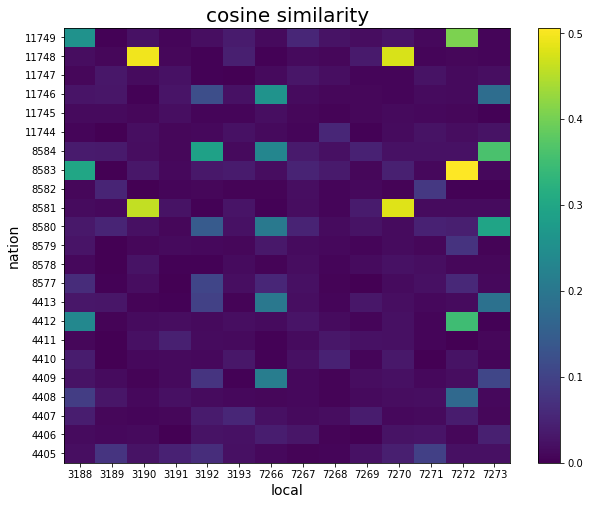

In [23]:
#실제로 보면 확인 가능
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
plt.pcolor(cosine_sim)
plt.xticks(np.arange(0.5, len(_local.index), 1), _local.index)
plt.yticks(np.arange(0.5, len(_nation.index), 1), _nation.index)
plt.title('cosine similarity', fontsize=20)
plt.xlabel('local', fontsize=14)
plt.ylabel('nation', fontsize=14)
plt.colorbar()

## binary 표현
- 지역이슈 = 1, 전국이슈 = 0

In [29]:
if len(set(nation_news_index).union(set(local_news_index))) == len(df_local):
    temp = []
    for i in df_local.index:
        temp.append(i in local_news_index)
    df_local['지역이슈'] = temp    

In [30]:
#지역뉴스가 다룬
print(f'지역뉴스 건수: {sum(df_local["지역이슈"] == True)}')
print(f'전국뉴스 건수: {sum(df_local["지역이슈"] != True)}')

지역뉴스 건수: 4594
전국뉴스 건수: 2680


# 같은 지역내 신문 비교

## 키워드 분석

In [31]:
print(set(df_local.언론사))
df_local_1 = df_local[df_local.언론사 == '부산일보'] #top1
df_local_2 = df_local[df_local.언론사 == '국제신문'] #top2

{'국제신문', '부산일보'}


In [33]:
# 전국일보랑 겹치는 지역일보 삭제
df_local['유사도_max'] = None
df_local['유사도_mean'] = None
# cosine similarity 구해서 일정 수준 넘으면 유사도 높은것으로 간주
for i in date_range("20110602", "20151231"):
    #print(i)
    try:
        _local_1 = df_local_1[(df_local_1.일자 >= i-1) & (df_local_1.일자 <= i+1)]
        _local_2 = df_local_2[(df_local_2.일자 >= i-1) & (df_local_2.일자 <= i+1)]

        _len_local_1 = len(_local_1)
        _len_local_2 = len(_local_2)

        data = pd.concat([_local_1,_local_2])

        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_mat_nation = tfidf.fit_transform(data['본문_full']) #본문_full, 특성추출(가중치순 상위 50개), 키워드
        #print('TF-IDF 행렬의 크기(shape) :',tfidf_mat_nation.shape)

        cosine_sim = cosine_similarity(tfidf_mat_nation[:_len_local_1], tfidf_mat_nation[_len_local_1:])
        #print(_len_nation)
        #print('코사인 유사도 연산 결과 :',cosine_sim.shape)
        
        #기사의 유사도측정
        #수정해야함!!(계속 덮어쓰게 되어있음)
        #Top1
        for i in range(len(_local_1)):
            df_local['유사도_max'].loc[_local_1.index[i]] = np.max(cosine_sim[i])
            df_local['유사도_mean'].loc[_local_1.index[i]] = np.mean(cosine_sim[i])
        #Top2
        for i in range(len(_local_2)):
            tr = cosine_sim.transpose()
            df_local['유사도_max'].loc[_local_2.index[i]] = np.max(tr[i])
            df_local['유사도_mean'].loc[_local_2.index[i]] = np.mean(tr[i])
    except:
        print(i, end = ' ')

#data[['본문_full','언론사']] #: data 확인

20110605 20110606 20110607 20110608 20110609 20110610 

/Users/jihyejung/opt/anaconda3/envs/DL/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


20110611 20110612 20110624 20110625 20110626 20110701 20110702 20110703 20110704 20110705 20110706 20110707 20110708 20110709 20110710 20110711 20110712 20110713 20110714 20110715 20110716 20110717 20110718 20110719 20110720 20110721 20110722 20110723 20110724 20110725 20110726 20110727 20110728 20110729 20110730 20110731 20110801 20110807 20110808 20110809 20110810 20110817 20110822 20110823 20110829 20110908 20110911 20110912 20110913 20110914 20111001 20111030 20111031 20111107 20111120 20111121 20111122 20111123 20111124 20111125 20111126 20111203 20111204 20111205 20111206 20111207 20111208 20111209 20111210 20111211 20111212 20111213 20111214 20111215 20111216 20111217 20111218 20111219 20111220 20111221 20111222 20111223 20111224 20111225 20111226 20111227 20111228 20111229 20111230 20111231 20120101 20120102 20120103 20120104 20120105 20120106 20120107 20120108 20120109 20120110 20120111 20120112 20120113 20120114 20120115 20120116 20120117 20120118 20120119 20120120 20120121 2

In [94]:
#_local_1.index[i]
#cosine_sim.transpose()[1]

array([0.04203058, 0.0173783 , 0.02706351, 0.02068892, 0.04541737,
       0.17278789, 0.02157458, 0.03761215])

### heatmap

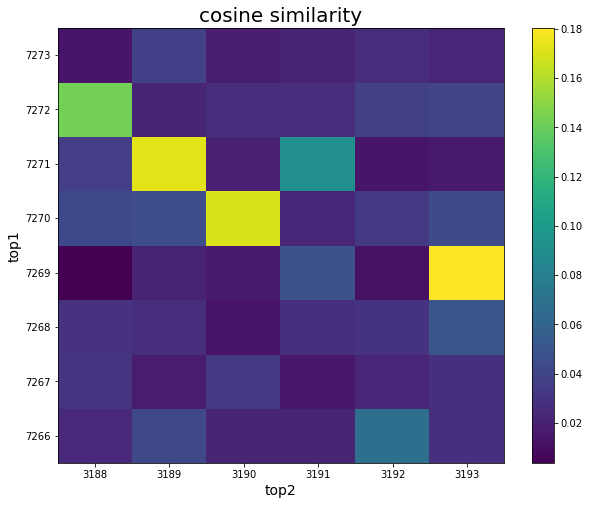

In [81]:
#실제로 보면 확인 가능
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
plt.pcolor(cosine_sim)
plt.xticks(np.arange(0.5, len(_local_2.index), 1), _local_2.index)
plt.yticks(np.arange(0.5, len(_local_1.index), 1), _local_1.index)
plt.title('cosine similarity', fontsize=20)
plt.xlabel('top2', fontsize=14)
plt.ylabel('top1', fontsize=14)
plt.colorbar()

## 감정분석

## 유사치 도출

# OLS
- y = Xb+ u
    - y: 유사도
    - X: 지역/ 전국 binary
    - cov: region, time, topic fixed effect…?, 

In [34]:
from statsmodels.formula.api import ols

#Na drop
#df_local.info() #na가 존재한다.
df = df_local[df_local.유사도_max.notna()]

In [36]:
#df['topic'] = df['통합 분류1'].astype('category')
#df['top1'] = df['언론사'].astype('category')
df['topic_1'] = df['통합 분류1'].astype('category').cat.codes
df['top1_1'] = df['언론사'].astype('category').cat.codes
df['year'] = df.일자.apply(lambda x: int(str(x)[:4]))
df['month'] = df.일자.apply(lambda x: int(str(x)[4:6]))
df['지역이슈'] = df['지역이슈'].astype('int')
df['유사도_max'] = df['유사도_max'].astype('float')
df['유사도_mean'] = df['유사도_mean'].astype('float')

/Users/jihyejung/opt/anaconda3/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jihyejung/opt/anaconda3/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jihyejung/opt/anaconda3/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A

In [38]:
df.groupby('지역이슈').mean()

,뉴스 식별자,일자,기고자,유사도_max,유사도_mean,topic_1,top1_1,year,month
지역이슈,,,,,,,,,
0,1.500551e+06,2.013687e+07,NaN,0.089950,0.034263,51.026695,0.497881,2013.614407,7.076695
1,1.500557e+06,2.013648e+07,NaN,0.053792,0.026879,55.307692,0.519170,2013.573668,7.243308


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6507 entries, 0 to 7273
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   뉴스 식별자             6507 non-null   float64
 1   일자                 6507 non-null   int64  
 2   언론사                6507 non-null   object 
 3   기고자                0 non-null      float64
 4   제목                 6507 non-null   object 
 5   통합 분류1             6507 non-null   object 
 6   통합 분류2             5265 non-null   object 
 7   통합 분류3             4153 non-null   object 
 8   사건/사고 분류1          1241 non-null   object 
 9   사건/사고 분류2          286 non-null    object 
 10  사건/사고 분류3          75 non-null     object 
 11  인물                 2870 non-null   object 
 12  위치                 6016 non-null   object 
 13  기관                 6483 non-null   object 
 14  키워드                6507 non-null   object 
 15  특성추출(가중치순 상위 50개)  6507 non-null   object 
 16  본문                 6507 

In [186]:
#os.getcwd()
df.to_csv('../data/df_ols.csv',encoding = 'utf-8-sig')

In [167]:
model = ols(formula = '유사도_mean ~ 지역이슈+ 일자 + top1 +topic',data = df).fit()
print(model.summary())
with open('../result/summary.txt', 'w') as fh:
    fh.write(model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:               유사도_mean   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     11.83
Date:                Mon, 10 Apr 2023   Prob (F-statistic):          2.83e-141
Time:                        22:12:58   Log-Likelihood:                 19778.
No. Observations:                6507   AIC:                        -3.939e+04
Df Residuals:                    6423   BIC:                        -3.882e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [155]:
model = ols(formula = '유사도_max~ 지역이슈+ 일자 + top1 +topic',data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                유사도_max   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     13.57
Date:                Mon, 10 Apr 2023   Prob (F-statistic):          4.09e-166
Time:                        22:08:46   Log-Likelihood:                 9927.0
No. Observations:                6507   AIC:                        -1.969e+04
Df Residuals:                    6423   BIC:                        -1.912e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1